# Playing with ensembles of Born Classifiers

I'd like to make Born Classifiers perform better.

Ensembling is a natural attempt to do so, and, in our case, it also provides us with an interesting quantum-mechanical interpretation: because a single Born Classifier collapses a wave function (as per Born's Rule), an ensemble of Born Classifiers collapse multiple wave functions.
In a sense, one increases the superposition posibilities by adding classifiers, maintaining multiple "interpretation" of the data simultaneously.

Naturally, we're operating with classical computers, thus the above is just a conceptual analogy.
Nevertheless, it is promising: by better exploring the superposition space we might get to better optima!

Practically speaking, ensembling is a particularly good idea for Born Classifier precisely because they're rather efficient.

In [1]:
from sklearn.datasets import make_classification
from sklearn.preprocessing import MinMaxScaler
from sklearn.utils import shuffle
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, precision_recall_fscore_support, roc_auc_score, confusion_matrix
from sklearn.ensemble import AdaBoostClassifier, StackingClassifier, BaggingClassifier, VotingClassifier

from time import time

import matplotlib.pyplot as plt 
import seaborn as sns

import numpy as np
import pandas as pd

from bornrule import BornClassifier

## Dataset creation

In [2]:
def create_dataset(n_samples=10000, n_features=50, n_informative=15, n_redundant=10, n_clusters_per_class=3, class_sep=0.8, n_classes=3):
    X, y = make_classification(n_samples=n_samples, n_features=n_features, n_informative=n_informative,
                               n_redundant=n_redundant, n_clusters_per_class=n_clusters_per_class,
                               class_sep=class_sep, n_classes=n_classes, random_state=42)
    
    # need non-negative features
    scaler = MinMaxScaler()
    X = scaler.fit_transform(X)
    
    # add noise
    X += np.random.normal(0, 0.05, X.shape)
    X = np.clip(X, 0, 1)
    
    # add non-linearity
    X = np.column_stack([X, np.sin(X[:, 0] * X[:, 1] * np.pi)])
    X = np.column_stack([X, np.exp(X[:, 2] * X[:, 3])])
    X = np.column_stack([X, np.log1p(X[:, 4] * X[:, 5])])
    
    X, y = shuffle(X, y, random_state=42)
    return X, y

In [3]:
X, y = create_dataset()

print(f"Dataset shape: {X.shape}")
print(f"Number of classes: {len(np.unique(y))}")
print(f"Class distribution: {np.bincount(y)}")
print(f"Feature value range: [{X.min():.4f}, {X.max():.4f}]")

Dataset shape: (10000, 53)
Number of classes: 3
Class distribution: [3336 3339 3325]
Feature value range: [0.0000, 1.9507]


In [4]:
X_train_val, X_test, y_train_val, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)
X_train, X_val, y_train, y_val = train_test_split(X_train_val, y_train_val, test_size=0.25, random_state=42, stratify=y_train_val)

print(f"Train set shape: {X_train.shape}")
print(f"Validation set shape: {X_val.shape}")
print(f"Test set shape: {X_test.shape}")

Train set shape: (6000, 53)
Validation set shape: (2000, 53)
Test set shape: (2000, 53)


## Evaluation

In [5]:
def evaluate_classifier(clf, X_train, y_train, X_val, y_val, X_test, y_test):
    start_time = time()
    clf.fit(X_train, y_train)
    train_time = time() - start_time
    
    start_time = time()
    y_val_pred = clf.predict(X_val)
    val_predict_time = time() - start_time
    
    val_accuracy = accuracy_score(y_val, y_val_pred)
    val_precision, val_recall, val_f1, _ = precision_recall_fscore_support(y_val, y_val_pred, average='weighted')
    val_roc_auc = roc_auc_score(y_val, clf.predict_proba(X_val), multi_class='ovr', average='weighted')
    
    y_test_pred = clf.predict(X_test)
    test_accuracy = accuracy_score(y_test, y_test_pred)
    
    return {
        'Validation Accuracy': val_accuracy,
        'Validation Precision': val_precision,
        'Validation Recall': val_recall,
        'Validation F1 Score': val_f1,
        'Validation ROC AUC': val_roc_auc,
        'Test Accuracy': test_accuracy,
        'Train Time': train_time,
        'Validation Predict Time': val_predict_time,
        'Validation Confusion Matrix': confusion_matrix(y_val, y_val_pred)
    }

In [6]:
classifiers = {
    'SingleBorn': BornClassifier(),
    'EnsembleBagging': BaggingClassifier(estimator=BornClassifier(), n_estimators=50, random_state=42),
    'EnsembleStacking': StackingClassifier(estimators=[(f"born_{i}", BornClassifier()) for i in range(50)], final_estimator=BornClassifier()),
    'EnsembleVoting': VotingClassifier(estimators=[(f"born_{i}", BornClassifier()) for i in range(50)], voting='soft'),
    'EnsembleAdaBoost': AdaBoostClassifier(estimator=BornClassifier())
}

In [7]:
results = {}
for name, clf in classifiers.items():
    results[name] = evaluate_classifier(clf, X_train, y_train, X_val, y_val, X_test, y_test)
summary = pd.DataFrame(results).T
summary = summary.drop('Validation Confusion Matrix', axis=1)

summary

/Users/johndoe/Desktop/uni/nlp/bored/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/Users/johndoe/Desktop/uni/nlp/bored/lib/python3.12/site-packages/sklearn/ensemble/_weight_boosting.py:527: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(


,Validation Accuracy,Validation Precision,Validation Recall,Validation F1 Score,Validation ROC AUC,Test Accuracy,Train Time,Validation Predict Time
SingleBorn,0.4825,0.490532,0.4825,0.439854,0.675029,0.4815,0.006147,0.004552
EnsembleBagging,0.4785,0.482869,0.4785,0.446451,0.67549,0.483,0.123534,0.200116
EnsembleStacking,0.3325,0.110556,0.3325,0.165938,0.643298,0.3325,1.159626,0.248511
EnsembleVoting,0.4825,0.490532,0.4825,0.439854,0.675029,0.4815,0.122674,0.234885
EnsembleAdaBoost,0.465,0.446267,0.465,0.381039,0.68231,0.4775,0.789701,0.202542


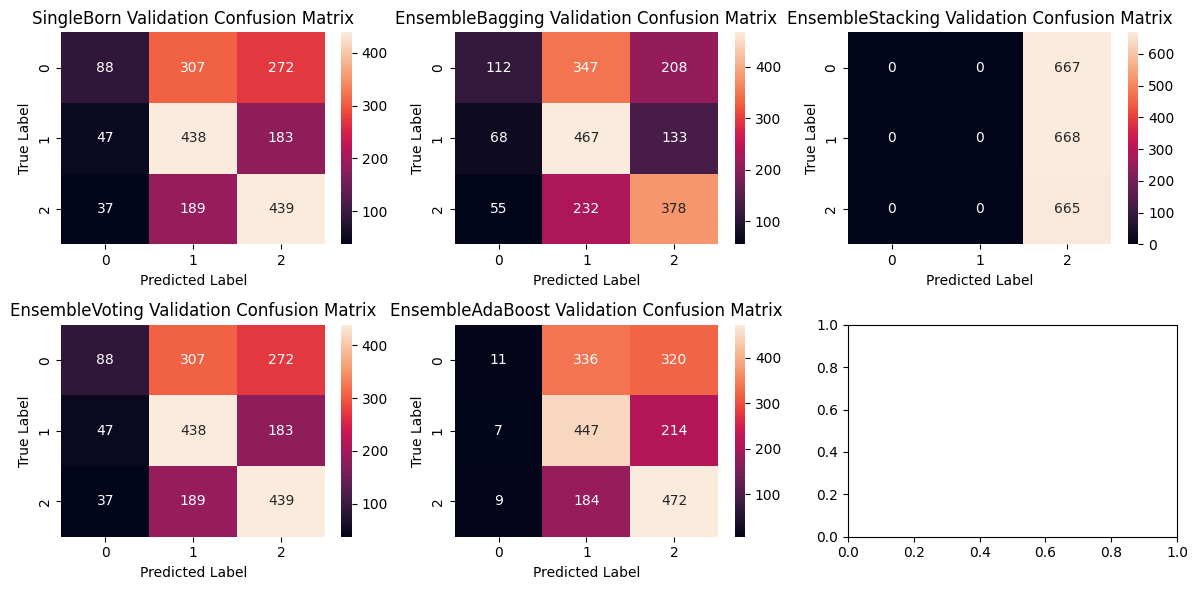

In [13]:
# let's look at the confusion matrices
fig, axes = plt.subplots(2, 3, figsize=(12, 6))
axes = axes.ravel()

for i, (name, result) in enumerate(results.items()):
    sns.heatmap(result['Validation Confusion Matrix'], annot=True, fmt='d', ax=axes[i])
    axes[i].set_title(f'{name} Validation Confusion Matrix')
    axes[i].set_xlabel('Predicted Label')
    axes[i].set_ylabel('True Label')

plt.tight_layout()
plt.show()

It seems like ensembling is almost entirely useless (if not outright damaging)!

That's quite surprising, but it could be related to the lack of stochasticity in Born's initialisation: for ensembles to work at their best, we need the single components to be as independent as possible, after all.

Let's try fiddling with the hyperparameters and see if we cannot improve things.

## Ensembles with different initial hyperparameters

Just as in the paper, we'll maintain `a`, `b` and `h` in the [0.0, 2.0] range.

In [9]:
def create_born_classifier_with_random_hyperparams():
    a, b, h = np.random.uniform(0.0, 2.01), np.random.uniform(0.0, 2.01), np.random.uniform(0.0, 2.01)
    return BornClassifier(a=a, b=b, h=h)

In [10]:
classifiers_rand = {
    'SingleBornRandom': create_born_classifier_with_random_hyperparams(),
    'EnsembleBaggingRandom': BaggingClassifier(
        estimator=create_born_classifier_with_random_hyperparams(), n_estimators=50, random_state=42),
    'EnsembleStackingRandom': StackingClassifier(
        estimators=[(f"born_{i}", create_born_classifier_with_random_hyperparams()) for i in range(50)], final_estimator=create_born_classifier_with_random_hyperparams()),
    'EnsembleVotingRandom': VotingClassifier(
        estimators=[(f"born_{i}", create_born_classifier_with_random_hyperparams()) for i in range(50)], voting='soft'),
    'EnsembleAdaBoostRandom': AdaBoostClassifier(
        estimator=create_born_classifier_with_random_hyperparams())
}

In [14]:
results_rand = {}
for name, clf in classifiers_rand.items():
    results_rand[name] = evaluate_classifier(clf, X_train, y_train, X_val, y_val, X_test, y_test)
summary_rand = pd.DataFrame(results_rand).T
summary_rand = summary_rand.drop('Validation Confusion Matrix', axis=1)

summary_rand

/Users/johndoe/Desktop/uni/nlp/bored/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/Users/johndoe/Desktop/uni/nlp/bored/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/Users/johndoe/Desktop/uni/nlp/bored/lib/python3.12/site-packages/sklearn/ensemble/_weight_boosting.py:527: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(
/Users/johndoe/Desktop/uni/nlp/bored/lib/pyt

,Validation Accuracy,Validation Precision,Validation Recall,Validation F1 Score,Validation ROC AUC,Test Accuracy,Train Time,Validation Predict Time
SingleBornRandom,0.4785,0.49175,0.4785,0.42326,0.681029,0.4905,0.00439,0.016544
EnsembleBaggingRandom,0.369,0.231626,0.369,0.273425,0.677337,0.371,0.158509,0.204583
EnsembleStackingRandom,0.348,0.213496,0.348,0.20834,0.641973,0.3535,1.25558,0.229271
EnsembleVotingRandom,0.4715,0.484409,0.4715,0.407284,0.679027,0.4895,0.106723,0.232119
EnsembleAdaBoostRandom,0.3325,0.110556,0.3325,0.165938,0.675406,0.3325,0.828352,0.208712


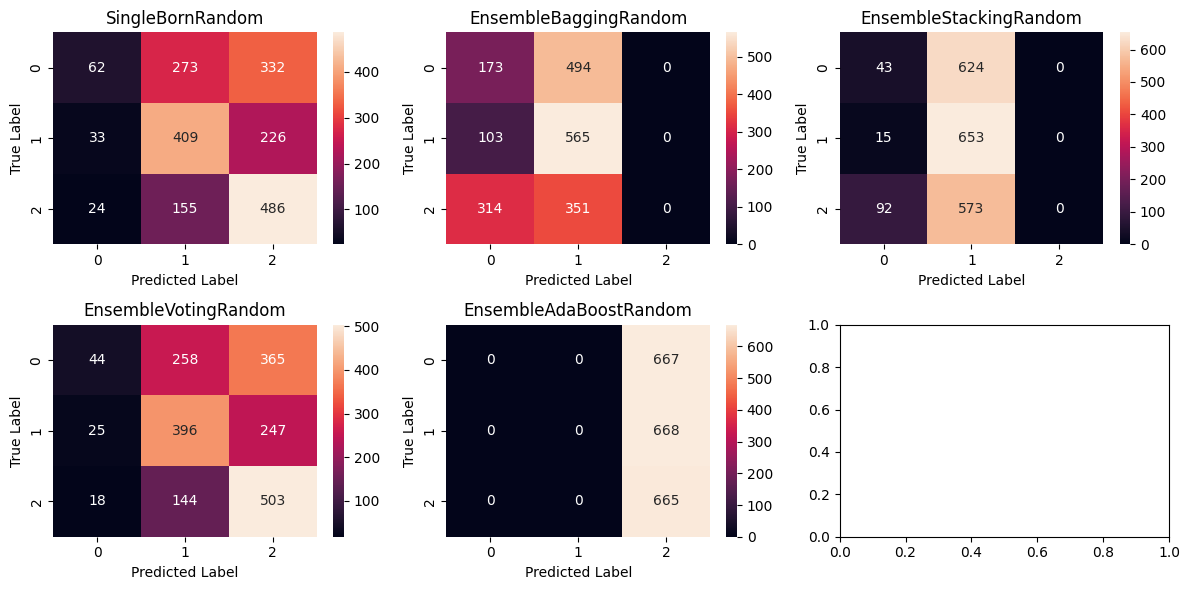

In [16]:
# let's look at the confusion matrices
fig, axes = plt.subplots(2, 3, figsize=(12, 6))
axes = axes.ravel()

for i, (name, result) in enumerate(results_rand.items()):
    sns.heatmap(result['Validation Confusion Matrix'], annot=True, fmt='d', ax=axes[i])
    axes[i].set_title(f'{name}')
    axes[i].set_xlabel('Predicted Label')
    axes[i].set_ylabel('True Label')

plt.tight_layout()
plt.show()

We do get some more variation in performance, so it seems like we did stumble upon something interesting!

Still, a single Born Classifier performs more or less best, and its training time completely dominates the ensemble classifiers.
Additionally, we expect ensembling to inerfere with explainability.

For all these reasons, we'll keep using a single Born Classifier (and because of explainability we will also avoid using Born Layers).